Student infomation  
Name:林澤宇  
Student id:112064528  
Github id:98965138  
kaggle name:NTHU112064528  
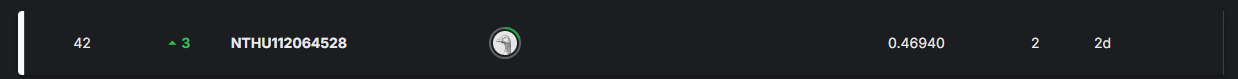

In [ ]:
import pandas as pd
import json
import re
import emoji
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchmetrics import Accuracy
from tqdm import tqdm
import nltk
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download NLTK resources for text preprocessing
nltk.download("punkt")
nltk.download("stopwords")

# Step 1: Load emotion and data identification datasets
# Read the CSV file containing emotion labels
emotion = pd.read_csv("/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv")
data_identification = pd.read_csv("/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv")

# Load and process tweets from the JSON file
with open("/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json", "r") as file:
    tweets_raw = [json.loads(line) for line in file]

tweets = pd.DataFrame([{
    "tweet_id": tweet["_source"]["tweet"]["tweet_id"],
    "text": tweet["_source"]["tweet"]["text"]
} for tweet in tweets_raw])

In [ ]:
# Merge `data_identification` with `tweets` on the common column "tweet_id"
merged_data = pd.merge(data_identification, tweets, on="tweet_id", how="left")
#Merge the result with `emotion` on "tweet_id"
merged_data = pd.merge(merged_data, emotion, on="tweet_id", how="left")

# 2.  Separate the merged dataset into training and testing sets
train_data = merged_data[merged_data["identification"] == "train"].copy()
test_data = merged_data[merged_data["identification"] == "test"].copy()

In [ ]:
# Step 3: Text preprocessing
stop_words = set(stopwords.words("english"))

#Steps:
#1. Convert emojis to descriptive words using `emoji.demojize`.
#2. Remove URLs (e.g., "http://example.com").
#3. Remove user mentions (e.g., "@username").
#4. Retain hashtags but remove other punctuation and special characters.
#5. Convert text to lowercase to ensure consistency.
#6. Remove stopwords to focus on meaningful words.
    
def preprocess_text(text):
    text = emoji.demojize(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^\w\s#\U0001F600-\U0001F64F]", "", text)
    text = text.lower()
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)  # required for BERT input

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

In [ ]:
#Step 4: Label processing
emotion_mapping = {emotion: idx for idx, emotion in enumerate(train_data["emotion"].unique())}
train_data["label"] = train_data["emotion"].map(emotion_mapping)
test_data["label"] = test_data["emotion"].map(emotion_mapping)

In [ ]:
from sklearn.model_selection import train_test_split

# train_data20% for val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

In [ ]:
train_data

In [ ]:
# 5. Define datasets and load data
class TwitterDataset(Dataset):
    #-data (DataFrame): The input data containing 'cleaned_text' and 'label' columns.
    #-tokenizer: The Hugging Face tokenizer for tokenizing text.
    #-max_length (int): The maximum sequence length for padding and truncation.
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['cleaned_text'] # Preprocessed text
        label = row['label']# Numeric label for the emotion
        # Tokenize the text and prepare it for the model
        encoding = self.tokenizer(
            text,
            padding="max_length",# Pad to the maximum sequence length
            truncation=True, # Truncate text longer than the maximum length
            max_length=self.max_length,# Maximum sequence length
            return_tensors="pt"# Return PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),# Tokenized IDs
            'attention_mask': encoding['attention_mask'].squeeze(0),# Attention mask
            'label': torch.tensor(label, dtype=torch.long) # Emotion label as a tensor
        }

    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    #- 'input_ids' (Tensor): Stacked input IDs for the batch.
    #- 'attention_mask' (Tensor): Stacked attention masks for the batch.
    #- 'labels' (Tensor): Stacked labels for the batch.
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [ ]:
# Step 6: Initialize BERT model and classifier
class EmotionClassifier(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_classes=8):
        #Initialize
        super(EmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Extract the [CLS] token output (first token) from the last hidden state
        cls_output = outputs.last_hidden_state[:, 0, :]  
        # Pass the [CLS] token output through the classifier to get logits
        logits = self.classifier(cls_output)
        return logits


In [ ]:
# Step 7: Initialize model, optimizer, and loss function
model = EmotionClassifier(num_classes=len(emotion_mapping)).to(device)
# Load the pre-trained BERT tokenizer for text preprocessing
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Step 8: Construct data loaders
max_length = 64
batch_size = 8
# Create DataLoader objects for batch processing
train_dataset = TwitterDataset(train_data, tokenizer, max_length)
#test_dataset = TwitterDataset(test_data, tokenizer, max_length)
val_dataset = TwitterDataset(val_data, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
# - `train_dataloader` is ready to provide batches for training.
# - `val_dataloader` is used for validating the model during training.

In [ ]:
# Step 9: Training and evaluation functions
#Function to train the model for one epoch.
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # Zero out the gradients for the optimizer
        optimizer.zero_grad()
        # Forward pass through the model
        logits = model(input_ids, attention_mask)
        # Compute the loss between predictions and true labels
        loss = loss_fn(logits, labels)
        # Backward pass to compute gradients
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the loss for reporting
        total_loss += loss.item()
    return total_loss / len(dataloader)
#Function to evaluate the model on a validation or test dataset.
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    # Initialize
    accuracy_metric = Accuracy(task="multiclass", num_classes=len(emotion_mapping)).to(device)
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Forward pass through the model
            logits = model(input_ids, attention_mask)
            # Compute the loss between predictions and true labels
            loss = loss_fn(logits, labels)
            # Accumulate the loss for reporting
            total_loss += loss.item()
            # Update the accuracy metric with the current batch predictions and labels
            accuracy_metric.update(logits.argmax(dim=1), labels)
    accuracy = accuracy_metric.compute().item()
    accuracy_metric.reset()
    # Return the average loss per batch and the overall accuracy
    return total_loss / len(dataloader), accuracy

In [ ]:
epochs = 1 #I only train for one epochs because of time. one epochs 5hr
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # train model
    train_loss = train(model, train_dataloader, optimizer, loss_fn, device)
    
    # val model
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn, device)
    # Print the training loss for this epoch
    print(f"Train Loss: {train_loss:.4f}")
    # Print the validation loss and accuracy for this epoch
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training Complete!")


In [ ]:
#save model
torch.save(model.state_dict(), "bert_emotion_model.pth")
print("Model saved as bert_emotion_model.pth")

In [ ]:
#Same as class TwitterDataset but return tweet_id
class TestTwitterDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['cleaned_text']
        tweet_id = row['tweet_id']

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'id': tweet_id  # return tweet_id
        }

    def __len__(self):
        return len(self.data)

In [ ]:
test_dataset = TestTwitterDataset(test_data, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def predict(model, dataloader, device):
    model.eval()
    predictions = [] # List to store predicted class labels
    ids = []   # List to store tweet IDs from the test dataset
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass through the model to get prediction logits
            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=1).cpu().numpy()  #Get predicted class labels
            predictions.extend(preds)
            ids.extend(batch['id'])  #Append tweet IDs to the list
    
    return ids, predictions

In [ ]:
model.load_state_dict(torch.load("bert_emotion_model.pth")) # Load model weights from a file
model.eval()   # Set the model to evaluation mode
print("Model loaded and ready for testing.")

# Use the model to make predictions on the test dataset
test_ids, test_predictions = predict(model, test_dataloader, device)

# Convert predicted numeric labels into emotion names
inverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}
test_emotions = [inverse_emotion_mapping[pred] for pred in test_predictions]

In [ ]:
# Create submission file
submission = pd.DataFrame({
    "id": test_ids,
    "emotion": test_emotions
})

# Save as CSV file
submission.to_csv("sampleSubmission.csv", index=False)
print("Submission file saved as sampleSubmission.csv")

In [ ]:
submission

In [ ]:
# Save as CSV file
submission.to_csv("/kaggle/working/sampleSubmission.csv", index=False)
print("Submission file saved at /kaggle/working/sampleSubmission.csv")
